In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing necessary libaries and tools

In [3]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

#Task-1

In [4]:

train_dir = "/content/drive/MyDrive/Artificial Intelligence and machine learning/FruitinAmazon/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/Artificial Intelligence and machine learning/FruitinAmazon/FruitinAmazon/test"

In [5]:
class_names = os.listdir(train_dir)
print(f"Classes: {class_names}")

Classes: ['tucuma', 'guarana', 'cupuacu', 'graviola', 'acai', 'pupunha']


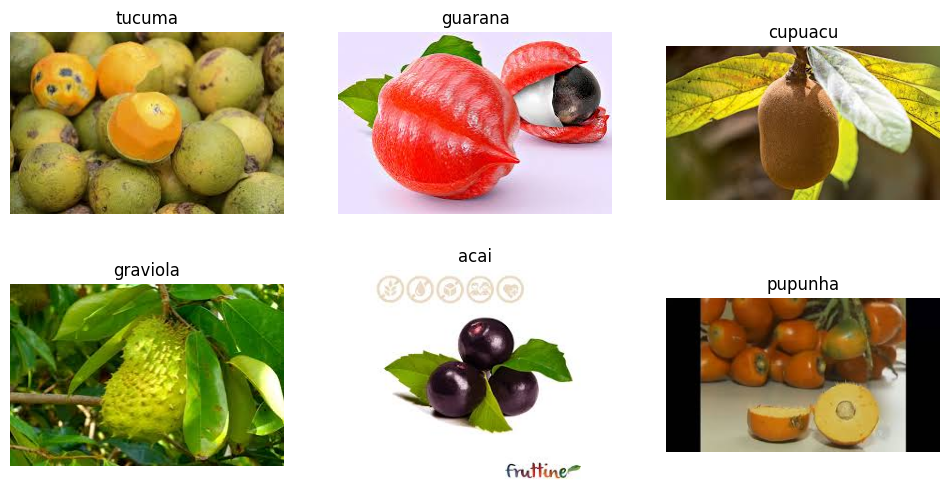

In [6]:
def visualize_images(train_dir, class_names):
    fig, axes = plt.subplots(2, len(class_names) // 2, figsize=(12, 6))
    axes = axes.flatten()
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis("off")
    plt.show()

visualize_images(train_dir, class_names)

In [7]:
damagedImages = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = load_img(img_path)  # Try opening the image
        except (IOError, SyntaxError):
            damagedImages.append(img_path)
            os.remove(img_path)
            print(f"Damaged image removed: {img_path}")

if not damagedImages:
    print("No Damaged Images Found.")

No Damaged Images Found.


In [13]:
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

In [10]:
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True,
    seed=123
)


Found 72 images belonging to 6 classes.


In [15]:
val_ds = val_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=False,
    seed=123
)

Found 18 images belonging to 6 classes.


In [16]:
num_classes = len(class_names)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001), input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,651,398 (128.37 MB)

 Trainable params: 33,650,438 (128.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    batch_size=16,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2847 - loss: 3.5301

3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.2865 - loss: 3.5217 - val_accuracy: 0.1667 - val_loss: 3.3032 - learning_rate: 0.0010
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4898 - loss: 2.7695

3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step - accuracy: 0.4785 - loss: 2.7813 - val_accuracy: 0.3333 - val_loss: 2.7044 - learning_rate: 0.0010
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 7s/step - accuracy: 0.3757 - loss: 2.6106 - val_accuracy: 0.2778 - val_loss: 2.8499 - learning_rate: 0.0010
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.5286 - loss: 2.2368 - val_accuracy: 0.2778 - val_loss: 3.1688 - learning_rate: 0.0010
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4333 - loss: 2.7750

3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step - accuracy: 0.4812 - loss: 2.6770 - val_accuracy: 0.3889 - val_loss: 3.9531 - learning_rate: 0.0010
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 8s/step - accuracy: 0.5750 - loss: 3.0479 - val_accuracy: 0.1667 - val_loss: 6.1392 - learning_rate: 5.0000e-04
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.7843 - loss: 2.1573 - val_accuracy: 0.1667 - val_loss: 8.5668 - learning_rate: 5.0000e-04


In [19]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 30 images belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2000 - loss: 2.6566
Test Accuracy: 20.00%


In [20]:
model.save("final_model.h5")
loaded_model = tf.keras.models.load_model("final_model.h5")

In [21]:
y_true = test_ds.classes
y_pred = np.argmax(loaded_model.predict(test_ds), axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

      tucuma       0.00      0.00      0.00         5
     guarana       0.00      0.00      0.00         5
     cupuacu       0.40      0.40      0.40         5
    graviola       0.19      0.80      0.31         5
        acai       0.00      0.00      0.00         5
     pupunha       0.00      0.00      0.00         5

    accuracy                           0.20        30
   macro avg       0.10      0.20      0.12        30
weighted avg       0.10      0.20      0.12        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


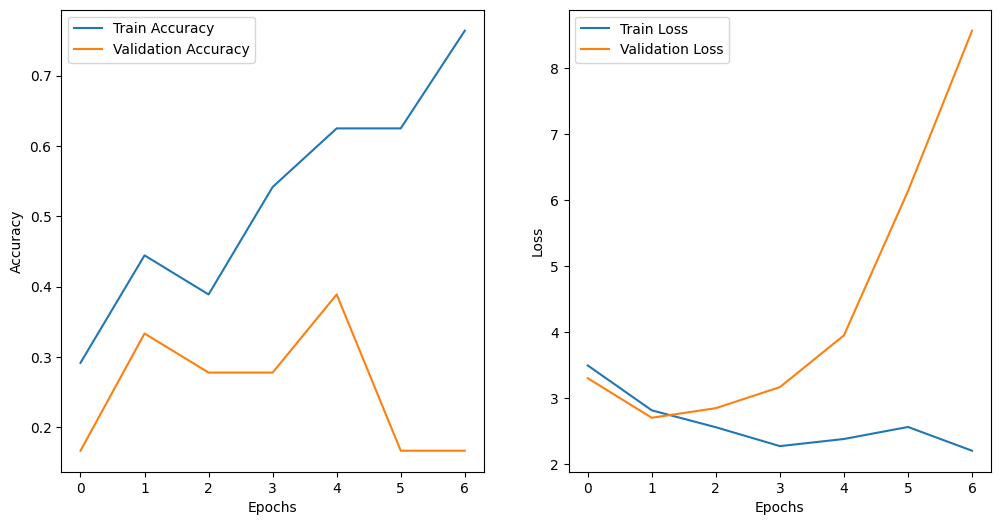

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#TASK-2

In [23]:
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [26]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
callbacks = [
    ModelCheckpoint("best_model_tl.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# Train the model (only top layers)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.1102 - loss: 2.6410

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.1278 - loss: 2.5946 - val_accuracy: 0.2778 - val_loss: 1.7749 - learning_rate: 0.0010
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2691 - loss: 2.0950

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 688ms/step - accuracy: 0.2747 - loss: 2.0849 - val_accuracy: 0.5556 - val_loss: 1.4108 - learning_rate: 0.0010
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.4319 - loss: 1.5250

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4385 - loss: 1.5231 - val_accuracy: 0.7222 - val_loss: 1.0687 - learning_rate: 0.0010
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.5330 - loss: 1.1230

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 592ms/step - accuracy: 0.5456 - loss: 1.1053 - val_accuracy: 0.7778 - val_loss: 0.8166 - learning_rate: 0.0010
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 582ms/step - accuracy: 0.7089 - loss: 0.8921 - val_accuracy: 0.7222 - val_loss: 0.7533 - learning_rate: 0.0010
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 557ms/step - accuracy: 0.8332 - loss: 0.5687 - val_accuracy: 0.7222 - val_loss: 0.7436 - learning_rate: 0.0010
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 786ms/step - accuracy: 0.9201 - loss: 0.3847 - val_accuracy: 0.7222 - val_loss: 0.7200 - learning_rate: 0.0010
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 856ms/step - accuracy: 0.7769 - loss: 0.5447 - val_accuracy: 0.7778 - val_loss: 0.6780 - learning_rate: 0.0010
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 800ms/step - accuracy: 0.9115 - loss: 0.3520 - val_accuracy: 0.7778 - val_loss: 0.6099 - learning_rate: 0.0010
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 597ms/step - accuracy: 0.9240 - loss: 0.2175 - val_accuracy: 0.7778 - v

In [28]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step - accuracy: 0.9333 - loss: 0.3263
Test Accuracy: 93.33%


In [29]:
model.save("final_model_tl.h5")

loaded_model = tf.keras.models.load_model("final_model_tl.h5")


In [33]:
y_true = test_ds.classes
y_pred_probs = loaded_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Inference Output: First 20 Samples:")
for i in range(20):
    true_label = class_names[int(y_true[i])]
    pred_label = class_names[int(y_pred[i])]
    print(f"{i+1}. True: {true_label} - Predicted: {pred_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
Inference Output: First 20 Samples:
1. True: tucuma - Predicted: tucuma
2. True: tucuma - Predicted: tucuma
3. True: tucuma - Predicted: tucuma
4. True: tucuma - Predicted: guarana
5. True: tucuma - Predicted: tucuma
6. True: guarana - Predicted: guarana
7. True: guarana - Predicted: guarana
8. True: guarana - Predicted: guarana
9. True: guarana - Predicted: guarana
10. True: guarana - Predicted: guarana
11. True: cupuacu - Predicted: cupuacu
12. True: cupuacu - Predicted: cupuacu
13. True: cupuacu - Predicted: cupuacu
14. True: cupuacu - Predicted: cupuacu
15. True: cupuacu - Predicted: cupuacu
16. True: graviola - Predicted: graviola
17. True: graviola - Predicted: graviola
18. True: graviola - Predicted: graviola
19. True: graviola - Predicted: graviola
20. True: graviola - Predicted: graviola


In [34]:

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

      tucuma       1.00      0.80      0.89         5
     guarana       0.83      1.00      0.91         5
     cupuacu       1.00      1.00      1.00         5
    graviola       1.00      1.00      1.00         5
        acai       1.00      0.80      0.89         5
     pupunha       0.83      1.00      0.91         5

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



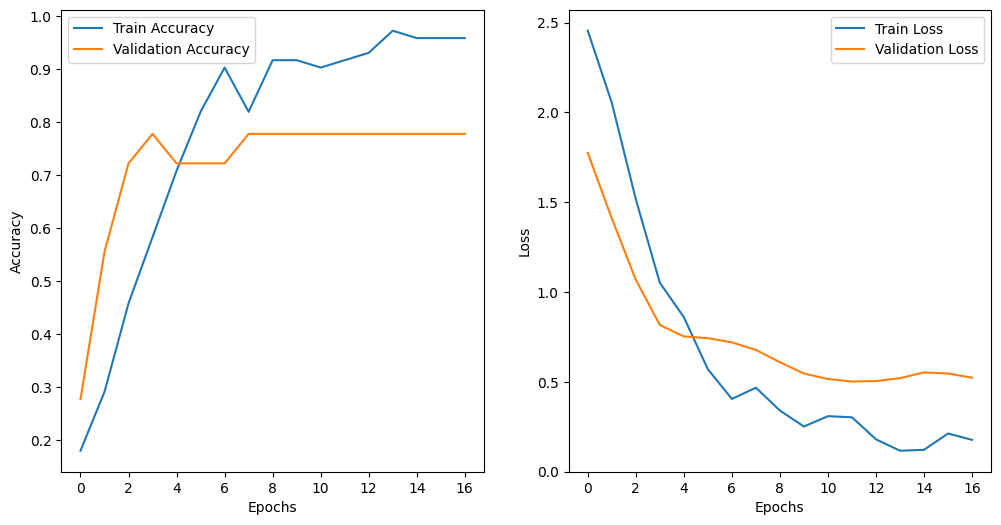

In [35]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()